# **Suicidal-Text-Analysis**

The suicide rate of patients with depression has been increasing in recent years. We trained this model by analyzing 232,074 pieces of text data. It is a machine learning-based algorithm for text classification and a computational method for semantic sentiment analysis. The experimental results show that it can effectively predict the sentiment of depression patients' blog posts on social media such as Twitter or Facebook. This allows physicians to intervene in advance when a depressed patient attempts to harm himself.

Step 1: We are read the dataset called "Suicide_Detection"

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('Suicide_Detection.csv')
print(data.head())

print()

   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide



Step 2: Check the dataset

In [3]:
print(f"Data shape {data.shape}")

print(f"Number of Unique Elements: {len(data['text'].unique())}")

Data shape (232074, 3)
Number of Unique Elements: 232074


Step 3: The dataset is selected and divided into training set and testing set

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop(labels=['class', 'Unnamed: 0' ], axis=1)
y = data['class']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)

Step 4: Perform feature extraction on the data of the training set. CountVectorizer is transform a given text into a vector on the basis of the count of each word that occurs in the entire text.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(x_train['text'])

print(x_train_counts.shape)

print(f"vocab => {count_vect.vocabulary_.get(u'disaster')}")

(174055, 142424)
vocab => 41683


Step 5: Perform feature extraction on the data of the training set. Tfidftransformer will compute word counts using CountVectorizer and then compute the IDF values and only then compute the Tf-idf scores

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
X_train_tfidf.shape

(174055, 142424)

Step 6: To classification of feature vectors in training sets by naive Bayes algorithm

In [7]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

We try a little demo with two values to see if the model works

In [8]:
docs_new = ['I wanna kill myself', 'I love KFC']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print(f'{doc} -> {category}')

I wanna kill myself -> suicide
I love KFC -> non-suicide


Luckily, it does.

Step 7: Call fit() to train and predict the algorithm model in the pipeline

In [9]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

text_clf.fit(x_train['text'], y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

Step 8: Visualize confusion matrix to analyze the results of train

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
def print_confusion_matrix(model,
                           confusion_matrix,
                           figsize = (8,8),
                           fontsize=12,
                           ylabel='True label',
                           xlabel='Predicted label'):


    class_names = model.classes_
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)


accuracy:-> 0.8819524638480498
              precision    recall  f1-score   support

 non-suicide       0.97      0.79      0.87     29074
     suicide       0.82      0.98      0.89     28945

    accuracy                           0.88     58019
   macro avg       0.90      0.88      0.88     58019
weighted avg       0.90      0.88      0.88     58019



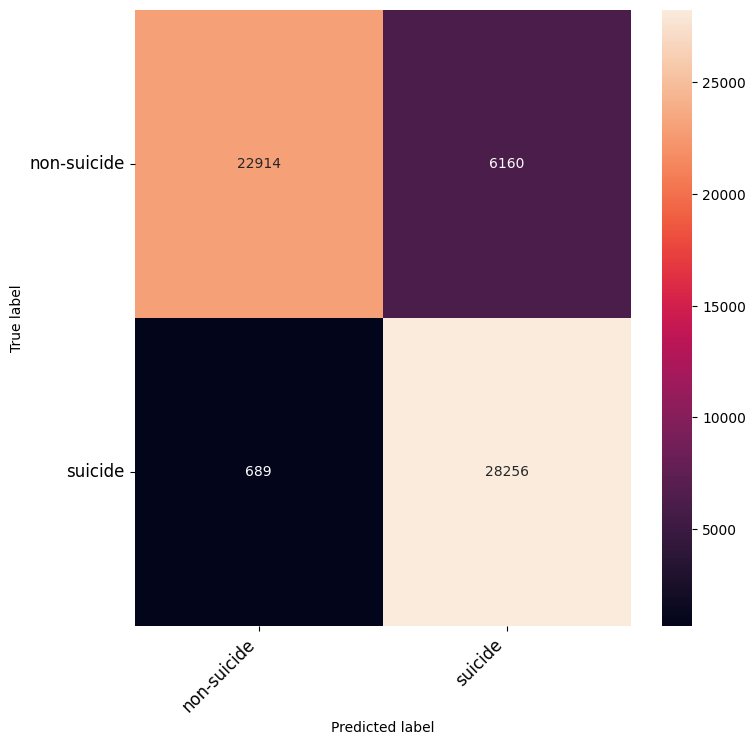

In [12]:
print(f"accuracy:-> {text_clf.score(x_test['text'],y_test)}")


from sklearn import metrics

docs_test = x_test['text']
predicted = text_clf.predict(docs_test)

print(metrics.classification_report(y_test, predicted ))

# print(metrics.confusion_matrix(y_test, predicted))

cm = metrics.confusion_matrix(y_test, predicted, labels=text_clf.classes_)

print_confusion_matrix(text_clf,confusion_matrix=cm)

Step 9: Classify data using stochastic gradient descent

In [13]:
from sklearn.linear_model import SGDClassifier
text_clf2 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=.0001, random_state=42,
                          max_iter=5, tol=None)),
])




Step 10: Visualize the results of stochastic gradient descent classification

accuracy:-> 0.9293679656664197
              precision    recall  f1-score   support

 non-suicide       0.92      0.95      0.93     29074
     suicide       0.94      0.91      0.93     28945

    accuracy                           0.93     58019
   macro avg       0.93      0.93      0.93     58019
weighted avg       0.93      0.93      0.93     58019



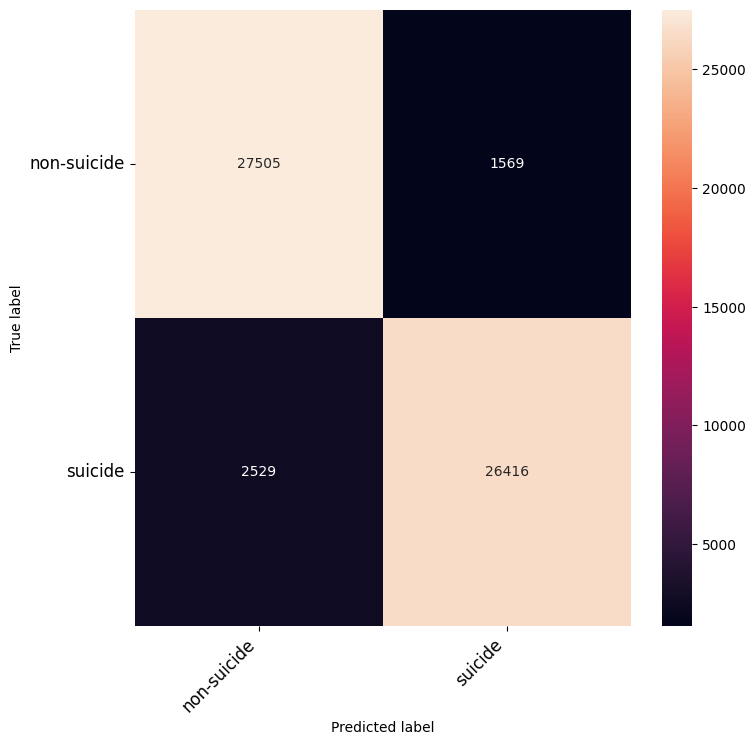

In [14]:
text_clf2.fit(x_train['text'], y_train)

predicted = text_clf2.predict(docs_test)
print (f"accuracy:-> {text_clf2.score(x_test['text'],y_test)}")


print(metrics.classification_report(y_test, predicted ))
# print(metrics.confusion_matrix(y_test, predicted))


cm = metrics.confusion_matrix(y_test, predicted, labels=text_clf2.classes_)

print_confusion_matrix(text_clf2,confusion_matrix=cm)

We Thereby can see that **text_clf2** gives us a better prediction. So we use it as out model of choice

In [15]:
best_model = text_clf2

We then export the model as an `.sav` file and use it for our web application as you will see. We have decided to use streamlit for easy of use.

In [16]:
import joblib

filename = 'finalized_model.sav'
joblib.dump(best_model, filename)

['finalized_model.sav']